# Introduction
The motivation behind this notebook is to determine how strong a password is. And not just by looking at entropy analysis or how complex a password is, but by looking at the correlation of password strength and how it varies when compared against a number of different categories which we can categorize the password string by.

# Background Research
It is so often said to us that we should use passwords that are not common words. But let's say my password is 'klo$0', instead of what I would usually use (not) 'y@tin'.

Both these passwords are 5 characters each. The idea is that a computer program can probably guess these passwords in an insignificant amount of time can be worrying. Let's just try it ourselves and see how long it would take for a computer to find these two passwords:

In [186]:
import time
import string
import random

# all the characters that can be used in a password
all_chars = string.ascii_uppercase + string.ascii_lowercase + string.punctuation + string.digits
slen = len(all_chars)
# calculating time for random 5 character string:
start_rand = time.time()
check = ''.join(random.choice(all_chars) for _ in range(5))
end_rand = time.time()
elapsed = end_rand - start_rand
print("It took {0:.10f} seconds to guess a random 5 character string from a range of characters {1} characters long".format(elapsed, slen))

It took 0.0007760525 seconds to guess a random 5 character string from a range of characters 94 characters long


We know that there are 5 possibilities, and we also know that there are 94 characters to chose from. So we can have 94^5 possible combinations of possible 5 character strings. As such, we can multiply the number of combinations with the amount of time it takes to compute one combination, and find out how much time (years) it would have at most taken to guess a random password of 5 characters. 

In [187]:
pos = 94 ** 5
total = pos * elapsed # total time taken
days = total / 86400 # seconds to days conversion
years = days / 365 # days to years conversion
print("It will take at most {0:.5} years to guess your 5 character password!".format(years))

It will take at most 0.1806 years to guess your 5 character password!


So if I don't change my password every few weeks, it could potentially be hacked. Now obviously my password is not that low, because let's observe what happens when we change the number of characters in the password from 5 to 12.

In [188]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# define function to check for how long it would take to generate passowrd of n characters from a set of char chars characters
pass_speeds = [] # parallel lists keeping track of speeds and corresponding number of chars
num_chars = []
def guess(n, chars):
    check = ''.join(random.choice(all_chars) for _ in range(n))
    pos = chars ** n
    total = pos * elapsed # total time taken
    days = total / 86400 # seconds to days conversion
    years = days / 365 # days to years conversion
    years = float("{0:.2f}".format(years))
    num_chars.append(str(n) + " characters")
    pass_speeds.append(str(years) + " years")


# call function from ranges of 5 to 12 to populate dictionary with values
for i in range(5,13):
    guess(i, 94)

# create data frame with speeds of corresponding password lengths
speeds = pd.DataFrame({"time taken to crack (94 character list)": pass_speeds, "length of password": num_chars})
pass_speeds=[]

Look at that, the longer your password is, the longer it will take to crack it using a computer. At this point it is probably right to think that it might be a bit overkill to make a password of anything near 9 characters. But remember that these operations can be made easier with synchronization of more than one computer together, and these computers that which can probably operate at much, much higher speeds than mine. This website https://www.password-depot.com/know-how/brute-force-attacks.htm shows to us that in the http://www.distributed.net/RC5/en project, multiple contributors can try up to a total of 800 billion keys per second. And this drastically decreases the amount of time needed to crack passwords of a length between 5-12.

In [189]:
import urllib
from bs4 import BeautifulSoup
from IPython.display import display, HTML

url = "https://www.password-depot.com/know-how/brute-force-attacks.htm"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'lxml') # getting html tags
table = soup.find('table', {'stdbl': ''}) # finding table with data 
char_speeds = {} # dictionary to extract password length and corresponding time to crack from table

rows = table.findChildren('p') # all the text in the table
# looping through the row to extract just the password length and time taken to extract
times = []
for cell in rows:
    times.append(cell.findAll("strong"))

# clean the list from the empty items
times = [x for x in times if len(x) != 0]

# loop and create the dictionary with keys and values representing password length and time taken to crack that password
sent = 0
while True:
    pl = str(times[sent])[9:-10]
    sent += 1
    tt = str(times[sent])[9:-10]
    char_speeds[pl] = tt
    sent += 1
    if sent == len(times):
        break

# make new dataframe showing the relationship
chsp = pd.DataFrame({"length of password": list(char_speeds.keys()),
                     "time taken to crack (94 character list)": list(char_speeds.values())})
print("at 800 billion keystrokes per second data\n","-----------------------")
display(chsp)
print("at my computer's speed\n","-----------------------")
display(speeds)

at 800 billion keystrokes per second data
 -----------------------


,length of password,time taken to crack (94 character list)
0,5 characters,0.03 seconds
1,7 characters,"approx, 9 minutes"
2,8 characters,"approx, 2,6 days"
3,9 characters,"approx, 9,1 years"
4,12 characters,"approx, 7,5 million years"


at my computer's speed
 -----------------------


,length of password,time taken to crack (94 character list)
0,5 characters,0.18 years
1,6 characters,16.98 years
2,7 characters,1595.8 years
3,8 characters,150005.54 years
4,9 characters,14100521.13 years
5,10 characters,1325448986.4 years
6,11 characters,124592204722.05 years
7,12 characters,11711667243872.44 years


It is clearly notable that even though it takes a signifcantly smaller amount of time to crack these passwords, given the proper resources. One that still stands out is the 12 character password, and this pretty much reinforces that if you have a 12 character password you are safe. But is this feature really being used? We can go through a sample of 61000+ passwords and check how many are actually over this limit.

# Analysis

In [190]:
p = pd.read_csv('8-more-passwords.txt', delim_whitespace=True, header=None) # reading csv with passwords
p.columns = ['Passwords']

In [191]:
# add lists categorizing the different types of chars
punc_in = string.punctuation # special characters (punctuation)
nums_in = "1234567890" # all the numbers
vows_in = "aeiouAEIOU" # all the vowels

After extracting the passwords from the text file, it is easy to then make lists of characters that categorize different traits for a string. So can then add the corresponding columns of these lists by looping through the passwords and adding up how many times each char falls into the categories.

In [192]:
# dicts for each category of char
keys = np.arange(61682)
punctuations = dict(zip(keys, [0] * len(keys)))
numbers = dict(zip(keys, [0] * len(keys)))
vowels = dict(zip(keys, [0] * len(keys)))
length = dict(zip(keys, [0] * len(keys)))
upper = dict(zip(keys, [0] * len(keys)))
lower = dict(zip(keys, [0] * len(keys)))
# list that contains these dicts
    
sent = 0 # sentinel keeps track of index in dicts
for i in p.loc[:, "Passwords"]:
    length[sent] = len(i)
    for char in i:
        if char in punc_in:
            punctuations[sent] += 1    
        if char in nums_in:
            numbers[sent] += 1 
        if char in vows_in:
            vowels[sent] += 1 
        if char.islower():
            lower[sent] += 1
        if char.isupper():
            upper[sent] += 1
    sent += 1

p["Length"] = pd.Series(length)
p["Punctuations"] = pd.Series(punctuations)
p["Numbers"] = pd.Series(numbers)
p["Vowels"] = pd.Series(vowels)
p["Uppercase"] = pd.Series(upper)
p["Lowercase"] = pd.Series(lower)
print("passwords data\n","-----------------------")
display(p.head())

passwords data
 -----------------------


,Passwords,Length,Punctuations,Numbers,Vowels,Uppercase,Lowercase
0,Ainslie1,8,0,1,4,1,6
1,146Dudley,9,0,3,2,1,5
2,Amanda94,8,0,2,3,1,5
3,Ambrose1,8,0,1,3,1,6
4,Yorkshire1,10,0,1,3,1,8


We can now plot this data to find how many passwords are "crackable" in a relatively unsafe amount of time. Anything more than around 10-11 characters is probably safe from a brute-force method of being cracked. 

length of the average passowrd is: 8.98 characters


8     33803
10    11337
9      9461
11     3339
12     1903
13      962
14      453
15      232
16      120
17       28
19       21
18       15
20        4
7         4
Name: Length, dtype: int64

passwords of length 8 make up 54.80% of all of the passwords


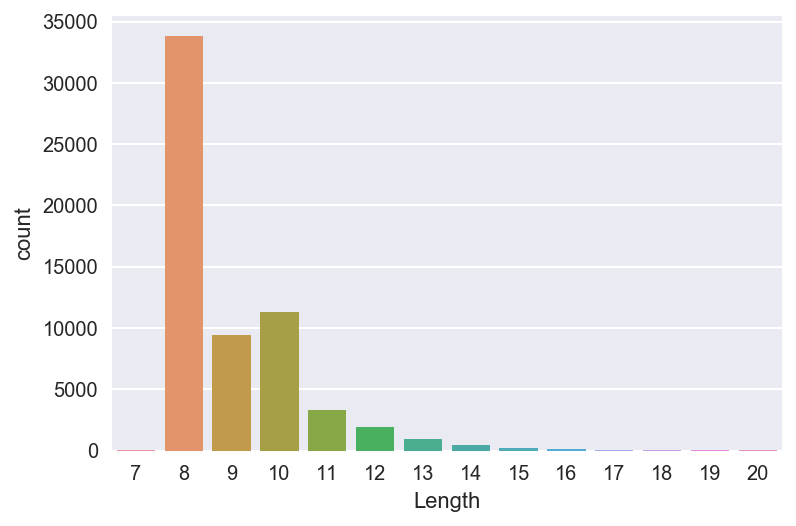

In [193]:
# graping with seaborn
sns.countplot(data=p, x="Length")
print("length of the average passowrd is: {0:.2f} characters".format(np.mean(p.Length)))
occ = p.Length.value_counts()
display(occ)
print("passwords of length 8 make up {0:.2f}% of all of the passwords".format(100*occ[8]/len(p)))

Pretty much what we find here is that 54.80% of the passwords in a sample of as many as 61628 passwords can be hacked in approx. 2.6 days, if we look at the webscraped data.

That was just considering that we look at all 94 characters. But looking at the data, we can see that not all passwords contain a character from each character category. To see a clear distribution of what category is used most commonly. 

punctuations are seen in 9.04% of all the passwords in the sample


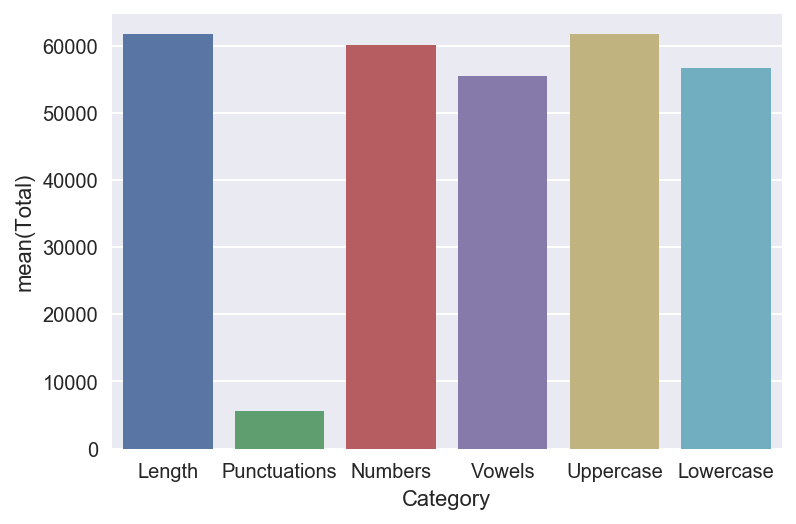

In [194]:
# making masked dataframe with true and false values
mp = (p.loc[:, "Length":"Lowercase"]>0).sum()
mask = pd.DataFrame({"Category": mp.index, "Total": mp.values})
sns.barplot(data=mask, x="Category", y="Total")
print("punctuations are seen in {0:.2f}% of all the passwords in the sample".format(100*mp["Punctuations"]/len(p)))

We know that the punctuation method in string contains 32 characters. The fact that less than 10% of passwords contain these punctuation characters. Recall that initially we had 94 characters from which we can choose combinations to find passwords. So essentially, it is a lot more easier to eliminate those 32 characters and reduce the list to 62 characters. And this makes things a lot easier to guess. We can do a comparison with the chart we came up with earlier:

In [195]:
for i in range(5,13):
    guess(i, 62)
pass_speeds
    
speeds["time taken to crack (62 character list)"] = pass_speeds
pass_speeds=[] # making the speeds list empty again for later use
speeds

,length of password,time taken to crack (94 character list),time taken to crack (62 character list)
0,5 characters,0.18 years,0.02 years
1,6 characters,16.98 years,1.4 years
2,7 characters,1595.8 years,86.66 years
3,8 characters,150005.54 years,5373.01 years
4,9 characters,14100521.13 years,333126.89 years
5,10 characters,1325448986.4 years,20653867.01 years
6,11 characters,124592204722.05 years,1280539754.82 years
7,12 characters,11711667243872.44 years,79393464798.65 years


So to be as safe as they can be, all passwords should contain these special punctuation characters. What we skip here is that we only checked the number of passwords that contain only punctuation characters. Ones that contain something from each category are ultimately the most safe passwords.

It would be easier to say that the longer your password, the better it is, but then if you use only numbers in the password, you face a total number 9^n possible combinations where n is the number of characters in the password. And that itself is so hard to memorize. What I'm trying to convey is that a computer will probably be programmed to guess passwords using these specific groups.

It will check the combinations of all the letters (upper and lower), numbers, and punctuations. So it's actually good to choose characters from these different groups to make the password safer. 

To come back to that point I made earlier, we don't know how many of these have a character from each of these categories. So let's find that out:

In [199]:
# masking everything to a boolean value
masked_vals = p.iloc[:, 1:]>0

# removing the false values from the entire table
for i in range(5):
    masked_vals = masked_vals[masked_vals.iloc[:, i]]
    
print("out of the", len(p), "passwords, there are only", len(masked_vals), "passwords that have a character from each category. that is {0:.2f}% of passwords that have a character from the set of those 94 characters.".format(100*len(masked_vals)/len(p)))

out of the 61682 passwords, there are only 3398 passwords that have a character from each category. that is 5.51% of passwords that have a character from the set of those 94 characters.


The average length, is less than 9 characters, and most of these passwords are made of characters from a subset of 62 characters. If we recall our table that uses data from a machine that can guess at 800 keystrokes per second, what we find is that at 94 characters, it took roughly ten years. So from a set of 62 characters, that time probably roughens down to less than 6 years (I'm just guessing). Meaning that the average password in this list of 61682 password can probably be cracked while that password is still being used. 

In [200]:
display(chsp)

,length of password,time taken to crack (94 character list)
0,5 characters,0.03 seconds
1,7 characters,"approx, 9 minutes"
2,8 characters,"approx, 2,6 days"
3,9 characters,"approx, 9,1 years"
4,12 characters,"approx, 7,5 million years"
